In [78]:
import datetime
import pytz
import copy
import glob
import os
import math 
import enum

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import mplfinance as mpf
from stock_indicators import indicators
from stock_indicators.indicators.common.quote import Quote

# Загрузка данных

In [79]:
#path = "data\\2024-GDM4"
path = "data\\2024-GDU4"

all_files = glob.glob(os.path.join(path, "*.csv"))
ticker_data = pd.concat((pd.read_csv(f, 
                            delimiter=";",
                            usecols=[1,2,3,4,5,6], 
                            names=['UTC', 'open', 'close','high','low','volume'],
                            dtype = {'UTC': 'str', 
                                      'open': 'float', 
                                      'close': 'float', 
                                      'high': 'float',
                                      'low': 'float',
                                      'volume': 'int'},
                            parse_dates=['UTC']
                           ) 
                for f in all_files), ignore_index=True)
ticker_data.index = pd.DatetimeIndex(ticker_data['UTC'])
ticker_data.drop(['UTC'], axis=1, inplace=True)

In [80]:
len(ticker_data)

87161

In [81]:
ticker_data

,open,close,high,low,volume
UTC,,,,,
2024-01-03 06:16:00+00:00,2156.7,2156.7,2156.7,2156.7,1
2024-01-03 06:20:00+00:00,2156.6,2156.6,2156.6,2156.6,1
2024-01-03 07:12:00+00:00,2153.0,2153.0,2153.0,2153.0,1
2024-01-03 07:28:00+00:00,2153.1,2153.1,2153.1,2153.1,1
2024-01-03 08:09:00+00:00,2152.1,2152.3,2152.3,2152.1,3
...,...,...,...,...,...
2024-09-20 10:54:00+00:00,2590.6,2590.6,2590.6,2590.6,1
2024-09-20 10:55:00+00:00,2590.6,2590.6,2590.6,2590.6,136
2024-09-20 10:57:00+00:00,2590.5,2590.6,2590.6,2590.5,4


# Описание стратегии

In [82]:
class StrategyStatus(enum.Enum):
    SEARCH = 1
    BULL = 2
    BEAR = 3

In [83]:
class StrategyCommand(enum.Enum):
    HOLD = 1
    BUY = 2
    SELL = 3
    CLOSE = 4

In [104]:
class Strategy:

    # текущее состояние
    status = status
    stop_loss = 0
    
    def __init__(self, status = StrategyStatus.SEARCH):
        
        # конфигурация
        self.frame_size = 22
        self.fractal_enabled = True
        self.fractal_size = 4
        
        self.alligator_signal = StrategyStatus.SEARCH
        self.fractal_signal = StrategyStatus.SEARCH
        self.status = status

    # Расчет индикаторов
    def calc_indicators(self, df ):
        quotes = [Quote(d,o,h,l,c,v) for d,o,h,l,c,v in zip(df.index, df['open'], df['high'], df['low'], df['close'], df['volume'])]
        alligator = indicators.get_alligator(quotes)
        fractal = indicators.get_fractal(quotes, fractal_size)
        result = df.copy()
        result["jaw"] = [ a.jaw for a in alligator]
        result["teeth"] = [ a.teeth for a in alligator]
        result["lips"] = [ a.lips for a in alligator]
        result["fractal_bear"] = [ f.fractal_bear if f.fractal_bear != None else np.nan for f in fractal]
        result["fractal_bull"] = [ f.fractal_bull if f.fractal_bull != None else np.nan for f in fractal]
        return result

    def get_params(self,data):
        l = len(data.index)
        index = data.index[max(l-1, 0)]
        fractal_index = data.index[max(l-fractal_size, 0)]
        return (
                index,
                data.at[index, 'open'], 
                data.at[index, 'close'],
                data.at[index, 'high'],
                data.at[index, 'low'],
                data.at[index, 'volume'],

                data.at[index, 'jaw'],
                data.at[index, 'teeth'],
                data.at[index, 'lips'],

                data.at[fractal_index, 'fractal_bear'],
                data.at[fractal_index, 'fractal_bull']
           )
    
    # обработка шага стратегии
    def next(self,data):

        # проверка полноты данных
        if ( len(data.index) < self.frame_size):
            self.status = StrategyStatus.SEARCH
            return StrategyCommand.HOLD, 0
        
        #инициализация локальных переменных
        indicators = self.calc_indicators(data)
        time, open_, close, high, low, volume, jaw, teeth, lips, fractal_bear, fractal_bull = self.get_params(indicators)
        
        # прерываем исполнение, если недостаточно данных
        if ( math.isnan(jaw) or 
             math.isnan(teeth) or 
             math.isnan(lips) or
             volume == 0 or 
             len(indicators.index) < self.frame_size):
            self.status = StrategyStatus.SEARCH
            return StrategyCommand.HOLD, 0

        #Определяем состояние индикатора аллигатора
        if   (lips > teeth and lips > jaw and lips < close and lips > low): 
            self.alligator_signal = StrategyStatus.BULL
        elif (lips < teeth and lips < jaw and lips > close and lips < high):
            self.alligator_signal = StrategyStatus.BEAR
        else:
            self.alligator_signal = StrategyStatus.SEARCH

        #Проверяем выход из лонга
        if( self.status == StrategyStatus.BULL):
            
            # выход по условиям
            if( 
                close < lips 
                or (not math.isnan(fractal_bear) and fractal_enabled) 
                or (power < 0 and power_enabled)
            ):
                self.status = StrategyStatus.SEARCH
                return StrategyCommand.CLOSE, self.stop_loss
            else:
                self.stop_loss = max(stop_loss, lips)

        #проверяем выход из шорта
        elif ( self.status == StrategyStatus.BEAR):
        
            # выход по условиям
            if( 
                close > lips 
                or (not math.isnan(fractal_bull) and fractal_enabled) 
            ):
                self.status = StrategyStatus.SEARCH
                return StrategyCommand.CLOSE, self.stop_loss
            else:
                stop_loss = min( stop_loss, lips)
    
        # ищем точку входа
        else:

            #лонгуем
            if   (alligator_signal == StrategyStatus.BULL): 
                self.status = StrategyStatus.BULL
                return StrategyCommand.BUY, lips
                    
            #шортим
            elif (alligator_signal == StrategyStatus.BEAR):
                self.status = StrategyStatus.BEAR
                return StrategyCommand.SELL, lips
        
        return StrategyCommand.HOLD, 0 

# Моделирование торговли

In [105]:
processed_data = ticker_data['2024-06-01 00:00:00':'2024-09-01 00:00:00']

In [106]:
len(processed_data)

50489

In [107]:
points = 0      # количесво выйграных пунктов цены
position = 0    # количество преобретенного инструмента
enter_price = 0
stop_loss = 0
bull_deals = 0
bear_deals = 0
points_log = []
bear_stop_loss = []
bull_stop_loss = []

# подготавливаем данные по дням
days_data = [group[1] for group in processed_data.groupby(processed_data.index.date)]

# запускаем цикл по дням
strategy = Strategy()
for day_data in days_data:

    # эмитация торговли внутри дня
    for index in day_data.index:
        target_loc = day_data.index.get_loc(index)
        start_loc = max(0, target_loc - frame_size)
        curient_frame = indicator_data.iloc[start_loc:target_loc + 1]

        # выход по лимиту
        if(   position > 0 and stop_loss > curient_frame['low' ][-1] ):
            strategy.status = StrategyStatus.SEARCH
            position = 0 
            points += stop_loss - enter_price
            bull_deals += 1
        elif( position < 0 and stop_loss < curient_frame['high'][-1] ):
            strategy.status = StrategyStatus.SEARCH
            position = 0 
            points += enter_price - stop_loss
            bear_deals += 1

        # выполняем шаг
        command, stop_loss = strategy.next(curient_frame)

        # Если нужно, выполняем закрытие позиций
        if(   command == StrategyCommand.BUY ):
            enter_price = curient_frame['close'][-1]
            position = 1
        elif( command == StrategyCommand.SELL):
            enter_price = curient_frame['close'][-1]
            position = -1
        elif( command == StrategyCommand.CLOSE and position > 0 ):
            points += curient_frame['close'][-1] - enter_price
            position = 0 
            bull_deals += 1
        elif( command == StrategyCommand.CLOSE and position < 0 ):
            points += enter_price - curient_frame['close'][-1]
            position = 0 
            bear_deals += 1

        points_log += [points]
        bull_stop_loss += [ stop_loss if status == StrategyStatus.BULL else np.nan ]
        bear_stop_loss += [ stop_loss if status == StrategyStatus.BEAR else np.nan ]

# Оценка результатов тестирования

In [108]:
leverage = 8

In [109]:
indicator_data = processed_data.copy()
indicator_data['points'] = points_log

In [110]:
mean_price = np.mean(indicator_data['close'])
print("Result: ", points, "pt. ", points/mean_price*leverage*100, "%"  ) 
print("Max: ", max(indicator_data['points']), "pt. ", max(indicator_data['points'])/mean_price*leverage*100, "%")
print("Min: ", min(indicator_data['points']), "pt. ", min(indicator_data['points'])/mean_price*leverage*100, "%")
print("Deals: ", bull_deals + bear_deals)
print("Bull deals: ", bull_deals)
print("Bear deals: ", bear_deals)

Result:  0 pt.  0.0 %
Max:  0 pt.  0.0 %
Min:  0 pt.  0.0 %
Deals:  0
Bull deals:  0
Bear deals:  0


In [30]:
#расчитываем распределение проседания
local_max = indicator_data['points'][0]
local_min = indicator_data['points'][0]
losses = []
for point in indicator_data['points']:
    if local_max < point:
        if local_max > local_min:
            losses += [{ "value": (local_max - local_min), "start": local_max["time"], "end": local_min["time"]}]
        local_max = point
        local_min = point
            
    elif local_min > point:
        local_min = point

max_loss_value = max([l["value"] for l in losses ])
for l in losses:
    if l["value"] == max_loss_value:
        print("Max loss:", max_loss_value, " start:", l["start"], " end:", l["end"], " days:", (l["end"] - l["start"]).days)
        break
print("3 sigma: ", np.var([l["value"] for l in losses ])*3)

Max loss: 20.177150488375446  start: 2024-06-04 15:23:00+00:00  end: 2024-06-06 07:38:00+00:00  days: 1
3 sigma:  44.58369865693954


In [29]:
points = 0
log = []
bull_deals = 0
bear_deals = 0
enter_price = 0
stop_loss = 0
alligator_signal = "search"
prev_alligator_signal = "search"
status = "search"
bear_stop_loss = []
bull_stop_loss = []
power = 0
for i in range(0, len(indicator_data.index)):
    time, open_, close, high, low, volume, jaw, teeth, lips, fractal_bear, fractal_bull = get_params(i)

    #заполняем графики нахождения в сделке
    bull_stop_loss += [ stop_loss if status == "bull" else np.nan ]
    bear_stop_loss += [ stop_loss if status == "bear" else np.nan ]
    
    #вычисляем значение изменения мощности тренда, если находимся в сделке, вне сделки вычисляем стартовое значение мощности
    if status == "search":
        power = 0
    power += (close - open_)*volume

    # заполняем лог текущими значениями
    log += [ {"points": points, "price":close, "time":time }]
    
    # отбрасываем незаполненные стартовые значения
    if ( math.isnan(jaw) or 
         math.isnan(teeth) or 
         math.isnan(lips) or
         volume == 0
       ):
        continue

    #Определяем состояние индикатора аллигатора
    prev_alligator_signal = alligator_signal
    if   (lips > teeth and lips > jaw and lips < close): 
        alligator_signal = "bull"
    elif (lips < teeth and lips < jaw and lips > close):
        alligator_signal = "bear"
    else:
        alligator_signal = "search"

    #Проверяем выход из лонга
    if status == "bull":

        # выход по лимиту
        if( stop_loss > low ):
            status = "search"
            points += stop_loss - enter_price
            bull_deals += 1
        
        # выход по условиям
        elif( 
                close < lips 
                or (not math.isnan(fractal_bear) and fractal_enabled) 
                or (power < 0 and power_enabled)
            ):
            status = "search"
            points += close - enter_price
            bull_deals += 1
        else:
            stop_loss = max(stop_loss, lips)

    #проверяем выход из шорта
    elif status == "bear":
        
        # выход по лимиту
        if( stop_loss < high ):
            status = "search"
            points += enter_price - stop_loss
            bear_deals += 1
        
        # выход по условиям
        elif( 
                close > lips 
                or (not math.isnan(fractal_bull) and fractal_enabled) 
                or (power > 0 and power_enabled)
            ):
            status = "search"
            points += enter_price - close
            bear_deals += 1
        else:
            stop_loss = min( stop_loss, lips)
    
    # ищем точку входа
    else:

        # отсекаем утренние и вечерние часы
        if time.hour * 60 + time.minute < 6*60+20:
            continue
        #лонгуем
        elif (alligator_signal == "bull" 
              and (prev_alligator_signal != alligator_signal or (not math.isnan(fractal_bull) and not fractal_enabled)) 
              and (power > 0 or not power_enabled)): 
            status = "bull"
            enter_price = close
            stop_loss = lips
        
        #шортим
        elif (alligator_signal == "bear" 
              and (prev_alligator_signal != alligator_signal or (not math.isnan(fractal_bear) and not fractal_enabled))  
              and (power < 0 or not power_enabled)):
            status = "bear"
            enter_price = close
            stop_loss = lips
            

indicator_data["bull_stop_loss"] = bull_stop_loss
indicator_data["bear_stop_loss"] = bear_stop_loss
    

Result:  554.6524893766045 pt.  175.14189520476955 %
Max:  563.2978202983754 pt.  177.78059659093432 %
Min:  0 pt.  0.0 %
Deals:  4153
Bull deals:  2184
Bear deals:  1969


# Визуализация

In [31]:
view_data = indicator_data.loc['2024-08-08 6:00:00':'2024-08-08 10:00:00']
view_data

,open,close,high,low,volume,jaw,teeth,lips,fractal_bear,fractal_bull,bull_stop_loss,bear_stop_loss
UTC,,,,,,,,,,,,
2024-08-08 06:59:00+00:00,2436.1,2436.1,2436.1,2436.1,778,2426.067756,2425.555555,2425.679739,NaN,NaN,NaN,NaN
2024-08-08 07:00:00+00:00,2436.1,2437.5,2438.4,2436.1,1294,2426.027929,2425.604861,2425.853791,NaN,NaN,NaN,NaN
2024-08-08 07:01:00+00:00,2437.5,2438.7,2438.8,2437.5,650,2425.975780,2425.685503,2425.953033,NaN,NaN,NaN,NaN
2024-08-08 07:02:00+00:00,2438.7,2438.8,2438.9,2438.7,524,2425.931489,2425.793565,2427.982426,NaN,NaN,NaN,NaN
2024-08-08 07:03:00+00:00,2438.9,2438.7,2438.9,2438.6,816,2425.932913,2425.863120,2429.835941,NaN,NaN,2427.982426,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-08 09:56:00+00:00,2435.0,2435.9,2435.9,2435.0,107,2434.449318,2434.634423,2434.882355,NaN,NaN,NaN,NaN
2024-08-08 09:57:00+00:00,2435.8,2435.8,2435.9,2435.6,54,2434.483986,2434.686370,2434.945884,NaN,NaN,NaN,NaN
2024-08-08 09:58:00+00:00,2435.9,2436.0,2436.2,2435.9,48,2434.519834,2434.750574,2434.976707,NaN,NaN,NaN,NaN


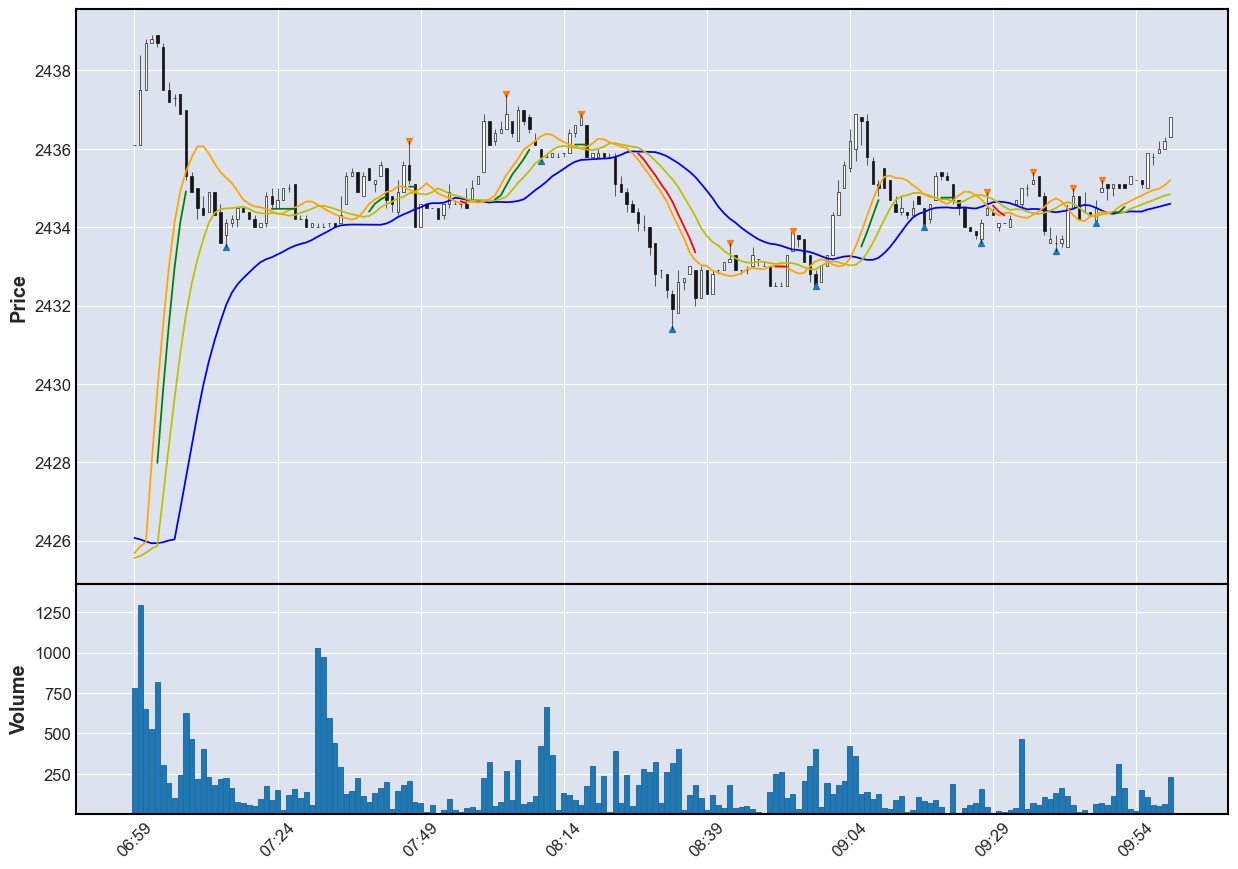

In [32]:

apds = [ mpf.make_addplot(view_data["jaw"],   color="b"),
         mpf.make_addplot(view_data["teeth"], color="y"),
         mpf.make_addplot(view_data["lips"],  color="orange"),
         mpf.make_addplot(view_data["fractal_bull"],   type='scatter', marker='^'),
         mpf.make_addplot(view_data["fractal_bear"],   type='scatter', marker='v'),
         mpf.make_addplot(view_data["bull_stop_loss"], color="g"),
         mpf.make_addplot(view_data["bear_stop_loss"], color="r")
       ]
mpf.plot(view_data, addplot=apds, type='candle', volume=True,figscale=2)

(array([53., 27., 16., 13., 11.,  9.,  7., 13.,  6.,  6.,  6.,  4.,  3.,
         1.,  1.,  2.,  3.,  4.,  2.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  2.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,
         2.,  0.,  0.,  0.,  1.]),
 array([1.05399483e-02, 4.68872006e-01, 9.27204064e-01, 1.38553612e+00,
        1.84386818e+00, 2.30220024e+00, 2.76053229e+00, 3.21886435e+00,
        3.67719641e+00, 4.13552847e+00, 4.59386053e+00, 5.05219258e+00,
        5.51052464e+00, 5.96885670e+00, 6.42718876e+00, 6.88552081e+00,
        7.34385287e+00, 7.80218493e+00, 8.26051699e+00, 8.71884905e+00,
        9.17718110e+00, 9.63551316e+00, 1.00938452e+01, 1.05521773e+01,
        1.10105093e+01, 1.14688414e+01, 1.19271734e+01, 1.23855055e+01,
        1.28438376e+01, 1.33021696e+01, 1.37605017e+01, 1.42188337e+01,
        1.46771658e+01, 1.51354979e+01, 1.55938299e+01, 1.60521620e+01,
        1.65104940e+01, 1.69688261e+01, 1.74271581e+01, 1.78854902e+01,
        1.83438223e+01, 1.

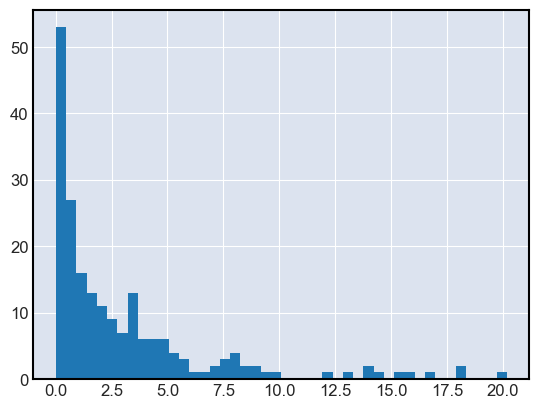

In [33]:
plt.hist([l["value"] for l in losses ], int(np.var([l["value"] for l in losses ])*3))